In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.stats import ttest_ind
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load results
df=pd.read_csv('/content/gdrive/MyDrive/DATA 606 Coding Files/Final_test_Predictions.csv')

In [ ]:
# Apply sentiment analysis via VADAR
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['input'].apply(lambda txt: sia.polarity_scores(txt)['compound'])

In [ ]:
# Flag misclassifications
df['is_misclassified'] = (df['label'] != df['predicted_labels'])
print(df.head())

                                               title  \
0   Drunk Bragging Trump Staffer Started Russian ...   
1   Pope Francis Just Called Out Donald Trump Dur...   
2   Racist Alabama Cops Brutalize Black Boy While...   
3   Fresh Off The Golf Course, Trump Lashes Out A...   
4   Trump Said Some INSANELY Racist Stuff Inside ...   

                                                text  label  title_tokens  \
0  House Intelligence Committee Chairman Devin Nu...      1            13   
1  Pope Francis used his annual Christmas Day mes...      1            13   
2  The number of cases of cops brutalizing and ki...      1            18   
3  Donald Trump spent a good portion of his day a...      1            19   
4  In the wake of yet another court decision that...      1            19   

   text_tokens text_summary  \
0          387          NaN   
1          477          NaN   
2          367          NaN   
3          481          NaN   
4          454          NaN   

             

In [ ]:
# Analyze sentiment by true label
df.groupby('label')['sentiment_score'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,21417.0,-0.023050,0.775296,-0.9990,-0.8706,0.0000,0.8126,0.9988
1,23481.0,-0.163917,0.785334,-0.9994,-0.9344,-0.4526,0.7412,0.9990


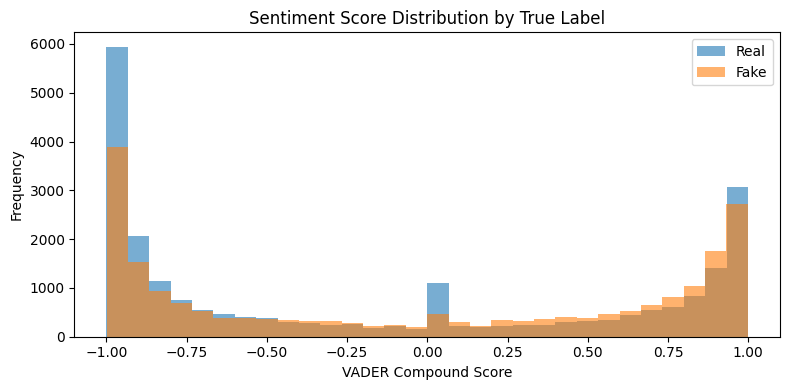

In [ ]:
# Compare sentiment distributions (real vs. fake)
plt.figure(figsize=(8,4))
for tag, label in zip([1,0], ['Real','Fake']):
    subset = df[df['label']==tag]
    plt.hist(subset['sentiment_score'], bins=30, alpha=0.6, label=label)
plt.title('Sentiment Score Distribution by True Label')
plt.xlabel('VADER Compound Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 600x400 with 0 Axes>

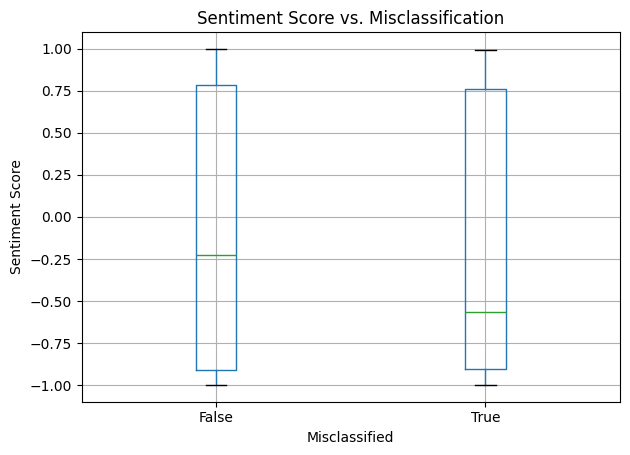

In [ ]:
# Relationship between misclassification and sentiment
plt.figure(figsize=(6,4))
df.boxplot(column='sentiment_score', by='is_misclassified')
plt.title('Sentiment Score vs. Misclassification')
plt.suptitle('')
plt.xlabel('Misclassified')
plt.ylabel('Sentiment Score')
plt.tight_layout()
plt.show()

In [ ]:
# Compute Flesch–Kincaid Reading Ease
def count_syllables(word):
    word = word.lower()
    vowels = 'aeiouy'
    groups = re.findall(r'[aeiouy]+', word)
    count = len(groups)
    return max(count, 1)

def fk_reading_ease(text):
    sentences = re.split(r'[.!?]+', text)
    sentences = [s for s in sentences if s.strip()]
    words = re.findall(r'\b\w+\b', text)
    syllables = sum(count_syllables(w) for w in words)
    ASL = len(words) / max(len(sentences),1)
    ASW = syllables / max(len(words),1)
    return 206.835 - 1.015 * ASL - 84.6 * ASW

df['reading_ease'] = df['input'].apply(fk_reading_ease)

Real mean RE: 47.61349342201029 Fake mean RE: 35.16214556118751
t-test p-value: 0.0


<Figure size 600x400 with 0 Axes>

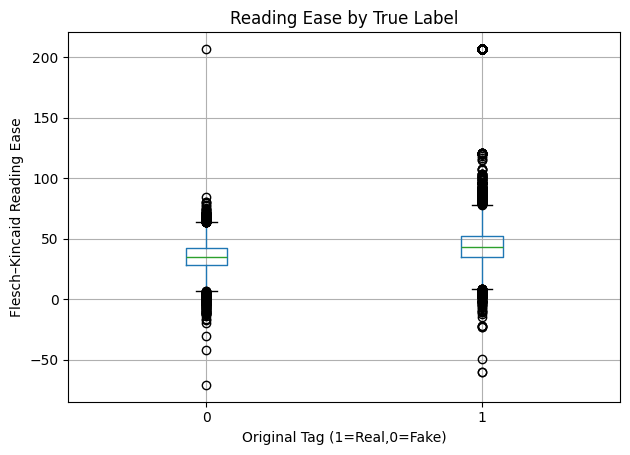

<Figure size 600x400 with 0 Axes>

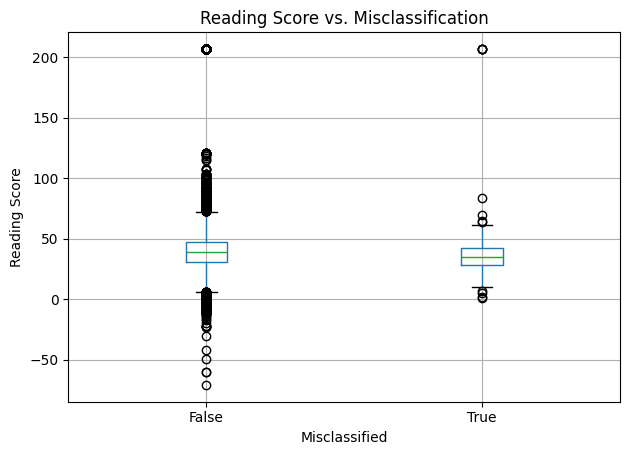

In [ ]:
# Compare readability (real vs. fake)
real = df[df['label']==1]['reading_ease']
fake = df[df['label']==0]['reading_ease']
print("Real mean RE:", real.mean(), "Fake mean RE:", fake.mean())
print("t-test p-value:", ttest_ind(real, fake, equal_var=False).pvalue)

plt.figure(figsize=(6,4))
df.boxplot(column='reading_ease', by='label')
plt.title('Reading Ease by True Label')
plt.suptitle('')
plt.xlabel('Original Tag (1=Real,0=Fake)')
plt.ylabel('Flesch–Kincaid Reading Ease')
plt.tight_layout()
plt.show()

# Relationship between misclassification and reading difficulty
plt.figure(figsize=(6,4))
df.boxplot(column='reading_ease', by='is_misclassified')
plt.title('Reading Score vs. Misclassification')
plt.suptitle('')
plt.xlabel('Misclassified')
plt.ylabel('Reading Score')
plt.tight_layout()
plt.show()

In [ ]:
# Inspect misclassified examples
mis = df[df['is_misclassified']]
print("Sample misclassified rows:")
display(mis[['label','predicted_labels','input']].head())

Sample misclassified rows:


,label,predicted_labels,input
4430,1,0,The CDC is investigating an outbreak of a bact...
4742,1,0,"More than 21,000 people from all regions of th..."
5931,1,0,Reuters reports:The United States expelled 35 ...
7401,1,0,
7620,1,0,"If Rubio would have dropped out a month ago, w..."


In [ ]:
# Feature patterns by correctness
df.groupby('is_misclassified')[['sentiment_score','reading_ease']].mean()

,sentiment_score,reading_ease
is_misclassified,,
False,-0.096034,41.730937
True,-0.158892,36.526291


/tmp/ipython-input-2404281497.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_rates = df.groupby('sent_bin')['is_misclassified'].mean()


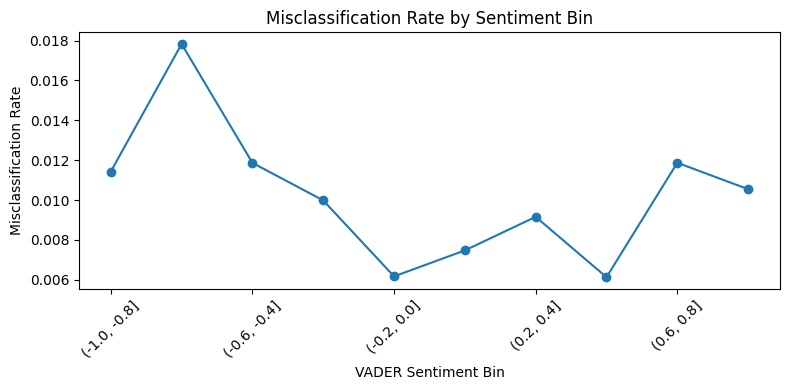

In [ ]:
correct = df[~df['is_misclassified']]
error = df[df['is_misclassified']]

# Confusion Matrix & Error Rates by Sentiment Bin
# Bin sentiment_score into intervals and compute misclassification rate per bin.
bins = np.linspace(-1, 1, 11)
df['sent_bin'] = pd.cut(df['sentiment_score'], bins)
bin_rates = df.groupby('sent_bin')['is_misclassified'].mean()

plt.figure(figsize=(8,4))
bin_rates.plot(marker='o')
plt.title('Misclassification Rate by Sentiment Bin')
plt.xlabel('VADER Sentiment Bin')
plt.ylabel('Misclassification Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Topic Modeling on Errors vs. Correct
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_err = tfidf.fit_transform(error['input'])
lda = LatentDirichletAllocation(n_components=3, random_state=0)
topics_err = lda.fit_transform(X_err)

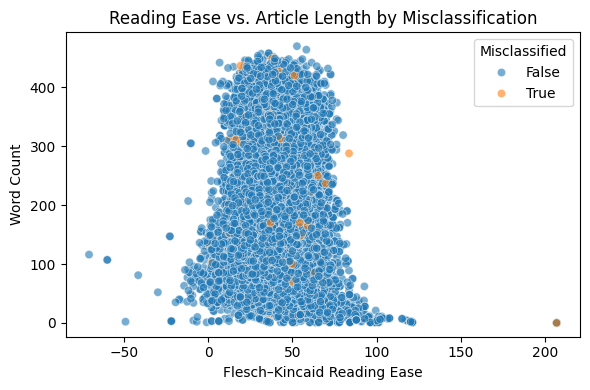

In [ ]:
# Readability vs. Article Length and Misclassification
df['word_count'] = df['input'].str.split().apply(len)
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='reading_ease', y='word_count', hue='is_misclassified', alpha=0.6)
plt.title('Reading Ease vs. Article Length by Misclassification')
plt.xlabel('Flesch–Kincaid Reading Ease')
plt.ylabel('Word Count')
plt.legend(title='Misclassified')
plt.tight_layout()
plt.show()

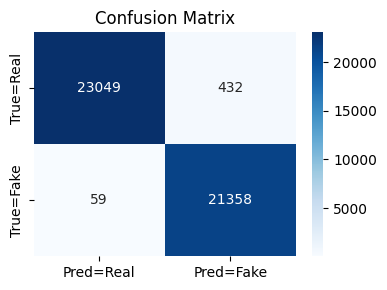

In [ ]:
# Confusion Matrix overall
cm = confusion_matrix(df['label'], df['predicted_labels'], labels=[1,0])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred=Real','Pred=Fake'],
            yticklabels=['True=Real','True=Fake'])
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True